In [71]:
#!pip install packaging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from packaging import version
import time

assert(version.parse(tf.__version__) >= version.parse("2.0.0-aplha"))

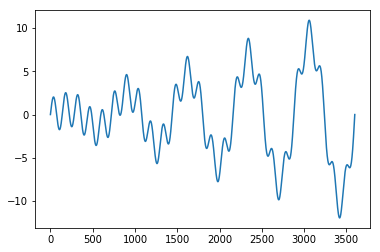

180


In [208]:
#t = np.arange(0., 10.*np.pi, np.pi / 360)
t = np.arange(0, 3601) * np.pi / 360.
data = np.array(t * np.sin(t)/3. + 2.*np.sin(t * 5.), dtype=np.float32)
#data /= max(abs(data)) / 2.
#spt_data = np.reshape(data[:3600], (-1, 20, 2))
#spt_lbl = np.reshape(data[1:3601], (-1, 20, 2))
spt_data = np.array(np.reshape(data[:3600], (-1, 20, 1)))
spt_lbl = np.array(np.reshape(data[1:3601], (-1, 20, 1)))

#print(len(spt_data[0]))
#print(len(spt_lbl [0]))
#print(spt_data[0])
#print(spt_lbl [0])

#print(len(t))
#plt.plot(t)
#plt.show()
plt.plot(data)
#plt.plot(spt_data)
plt.show()
print(len(spt_data))

In [209]:
#BATCH_SIZE = 64
BATCH_SIZE = 8
dataset = tf.data.Dataset.from_tensor_slices((spt_data, spt_lbl))
#dataset = tf.data.Dataset.from_tensor_slices(spt_data)
dataset = dataset.batch(BATCH_SIZE, True)
#print(dataset.take(64))
#for i,(a,b) in enumerate(dataset) : print("------", i, a, b)


In [238]:
class Encoder(tf.keras.Model):
  def __init__(self, hidden1, enc_units, batch_sz) : #, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.hidden1 = hidden1
    self.enc_units = enc_units
    #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    #self.inputi = tf.keras.Input(shape=(1,))
    #self.input_shape = tf.TensorShape([None,1])
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                    return_sequences=True,
                                    #return_state=True,
                                    stateful=True,
                                    activation="selu",
                                    #activation="linear",
                                    #recurrent_activation="selu",  
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(self.enc_units,
                                    activation="linear")

    #self.gru = tf.keras.layers.RNN(
    #    tf.keras.layers.GRUCell(self.enc_units,
    #                               recurrent_initializer='glorot_uniform'),
    #   return_sequences=True,
    #   return_state=True
    #)
    
  def call(self, x, initial_state=None): #, hidden):
    #print(x, initial_state)
    #x2 = self.inputi(x)
    #print(x2)
    if (initial_state!=None) :
        self.lstm.reset_states(initial_state)
    
    #output = self.lstm(x) #, initial_state = hidden)
    x = self.lstm(x) #, initial_state = hidden)
    output = self.dense(x)
    #output, self.state = self.lstm(x, self.state) #, initial_state = hidden)
    return output #, state

  #def reset_states(self) :
  #  self.lstm.reset_states()

  def reset_states(self, initial_state=None) :
    #print(self.lstm.input_spec)
    self.lstm.reset_states(initial_state)

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))
 

In [191]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError()
mask = np.concatenate((
    np.zeros((19,1), dtype=np.float32), 
    np.ones((1,1), dtype=np.float32)))
#print(mask)

def loss_function(real, pred):
    #print("loss_function")
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    #print(real, pred)
    real *= mask
    pred *= mask
    #print(real, pred)
    loss_ = loss_object(real, pred)
    #print(loss_)

    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
    #print(loss_)

    return tf.reduce_mean(loss_)


In [150]:
#@tf.function
def train_step(model, inputs, targets):
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(inputs)
        # Get the error/loss on these predictions
        loss = loss_function(targets, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    #train_loss(loss)
    #train_accuracy(targets, predictions)
    return loss

In [241]:
EPOCHS = 400

encoder = Encoder(10, 1, BATCH_SIZE)
encoder.build(tf.TensorShape([BATCH_SIZE, None, 1]))
encoder.summary()

#print(dataset)
#print(len(list(dataset)))
steps_per_epoch = len(list(dataset)) #//BATCH_SIZE
#print(steps_per_epoch)

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  encoder.reset_states()
  total_loss = 0

  #print(dataset)
  for (batch, (inp, targ)) in enumerate(dataset):
    #if (batch!=0) : continue
    #print(len(inp), len(targ))
    batch_loss = train_step(encoder, inp, targ)
    #print(batch_loss)
    total_loss += batch_loss

    if batch % 10 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
        
  print('Epoch {} Loss {:.4f}'.format(epoch + 1, 
                                      total_loss / steps_per_epoch))
#    break
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
#  break
  # saving (checkpoint) the model every 2 epochs
#  if (epoch + 1) % 2 == 0:
#    checkpoint.save(file_prefix = checkpoint_prefix)
#


Model: "encoder_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_66 (UnifiedLSTM multiple                  12        
_________________________________________________________________
dense_2 (Dense)              multiple                  2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
Epoch 1 Batch 0 Loss 0.1105
Epoch 1 Batch 10 Loss 0.9168
Epoch 1 Batch 20 Loss 1.1438
Epoch 1 Loss 1.0294
Time taken for 1 epoch 3.2800586223602295 sec

Epoch 2 Batch 0 Loss 0.1011
Epoch 2 Batch 10 Loss 0.8864
Epoch 2 Batch 20 Loss 1.1720
Epoch 2 Loss 1.0178
Time taken for 1 epoch 3.1941192150115967 sec

Epoch 3 Batch 0 Loss 0.0982
Epoch 3 Batch 10 Loss 0.8764
Epoch 3 Batch 20 Loss 1.2012
Epoch 3 Loss 1.0152
Time taken for 1 epoch 3.7610342502593994 sec

Epoch 4 Batch 0 Loss 0.0959
Epoch 4 Batch 10 Loss 0.8673
Epoch 

Epoch 50 Batch 0 Loss 0.0060
Epoch 50 Batch 10 Loss 0.2509
Epoch 50 Batch 20 Loss 0.0128
Epoch 50 Loss 0.1707
Time taken for 1 epoch 3.852137327194214 sec

Epoch 51 Batch 0 Loss 0.0058
Epoch 51 Batch 10 Loss 0.2458
Epoch 51 Batch 20 Loss 0.0124
Epoch 51 Loss 0.1681
Time taken for 1 epoch 3.322279453277588 sec

Epoch 52 Batch 0 Loss 0.0057
Epoch 52 Batch 10 Loss 0.2408
Epoch 52 Batch 20 Loss 0.0119
Epoch 52 Loss 0.1656
Time taken for 1 epoch 3.0980141162872314 sec

Epoch 53 Batch 0 Loss 0.0055
Epoch 53 Batch 10 Loss 0.2360
Epoch 53 Batch 20 Loss 0.0114
Epoch 53 Loss 0.1631
Time taken for 1 epoch 3.231201171875 sec

Epoch 54 Batch 0 Loss 0.0054
Epoch 54 Batch 10 Loss 0.2313
Epoch 54 Batch 20 Loss 0.0110
Epoch 54 Loss 0.1607
Time taken for 1 epoch 3.0648083686828613 sec

Epoch 55 Batch 0 Loss 0.0053
Epoch 55 Batch 10 Loss 0.2267
Epoch 55 Batch 20 Loss 0.0106
Epoch 55 Loss 0.1584
Time taken for 1 epoch 3.910508394241333 sec

Epoch 56 Batch 0 Loss 0.0052
Epoch 56 Batch 10 Loss 0.2223
Epoch 

Epoch 102 Batch 20 Loss 0.0032
Epoch 102 Loss 0.0884
Time taken for 1 epoch 3.450599431991577 sec

Epoch 103 Batch 0 Loss 0.0011
Epoch 103 Batch 10 Loss 0.0962
Epoch 103 Batch 20 Loss 0.0032
Epoch 103 Loss 0.0874
Time taken for 1 epoch 3.640829086303711 sec

Epoch 104 Batch 0 Loss 0.0010
Epoch 104 Batch 10 Loss 0.0946
Epoch 104 Batch 20 Loss 0.0032
Epoch 104 Loss 0.0865
Time taken for 1 epoch 3.1988258361816406 sec

Epoch 105 Batch 0 Loss 0.0010
Epoch 105 Batch 10 Loss 0.0930
Epoch 105 Batch 20 Loss 0.0032
Epoch 105 Loss 0.0855
Time taken for 1 epoch 3.067476511001587 sec

Epoch 106 Batch 0 Loss 0.0010
Epoch 106 Batch 10 Loss 0.0914
Epoch 106 Batch 20 Loss 0.0032
Epoch 106 Loss 0.0846
Time taken for 1 epoch 3.1922454833984375 sec

Epoch 107 Batch 0 Loss 0.0009
Epoch 107 Batch 10 Loss 0.0899
Epoch 107 Batch 20 Loss 0.0032
Epoch 107 Loss 0.0837
Time taken for 1 epoch 3.518932819366455 sec

Epoch 108 Batch 0 Loss 0.0009
Epoch 108 Batch 10 Loss 0.0884
Epoch 108 Batch 20 Loss 0.0032
Epoch 1

Epoch 154 Batch 0 Loss 0.0003
Epoch 154 Batch 10 Loss 0.0401
Epoch 154 Batch 20 Loss 0.0029
Epoch 154 Loss 0.0524
Time taken for 1 epoch 3.1320629119873047 sec

Epoch 155 Batch 0 Loss 0.0003
Epoch 155 Batch 10 Loss 0.0393
Epoch 155 Batch 20 Loss 0.0029
Epoch 155 Loss 0.0519
Time taken for 1 epoch 3.6151516437530518 sec

Epoch 156 Batch 0 Loss 0.0003
Epoch 156 Batch 10 Loss 0.0386
Epoch 156 Batch 20 Loss 0.0028
Epoch 156 Loss 0.0515
Time taken for 1 epoch 3.3481180667877197 sec

Epoch 157 Batch 0 Loss 0.0003
Epoch 157 Batch 10 Loss 0.0379
Epoch 157 Batch 20 Loss 0.0028
Epoch 157 Loss 0.0510
Time taken for 1 epoch 3.28289532661438 sec

Epoch 158 Batch 0 Loss 0.0003
Epoch 158 Batch 10 Loss 0.0372
Epoch 158 Batch 20 Loss 0.0028
Epoch 158 Loss 0.0505
Time taken for 1 epoch 3.264820098876953 sec

Epoch 159 Batch 0 Loss 0.0003
Epoch 159 Batch 10 Loss 0.0365
Epoch 159 Batch 20 Loss 0.0027
Epoch 159 Loss 0.0500
Time taken for 1 epoch 3.2240118980407715 sec

Epoch 160 Batch 0 Loss 0.0003
Epoch 1

Epoch 205 Batch 10 Loss 0.0130
Epoch 205 Batch 20 Loss 0.0014
Epoch 205 Loss 0.0330
Time taken for 1 epoch 3.2648797035217285 sec

Epoch 206 Batch 0 Loss 0.0002
Epoch 206 Batch 10 Loss 0.0127
Epoch 206 Batch 20 Loss 0.0014
Epoch 206 Loss 0.0327
Time taken for 1 epoch 3.1141114234924316 sec

Epoch 207 Batch 0 Loss 0.0002
Epoch 207 Batch 10 Loss 0.0123
Epoch 207 Batch 20 Loss 0.0014
Epoch 207 Loss 0.0324
Time taken for 1 epoch 3.171097993850708 sec

Epoch 208 Batch 0 Loss 0.0002
Epoch 208 Batch 10 Loss 0.0120
Epoch 208 Batch 20 Loss 0.0014
Epoch 208 Loss 0.0321
Time taken for 1 epoch 3.1967530250549316 sec

Epoch 209 Batch 0 Loss 0.0003
Epoch 209 Batch 10 Loss 0.0117
Epoch 209 Batch 20 Loss 0.0013
Epoch 209 Loss 0.0318
Time taken for 1 epoch 3.6953253746032715 sec

Epoch 210 Batch 0 Loss 0.0002
Epoch 210 Batch 10 Loss 0.0113
Epoch 210 Batch 20 Loss 0.0013
Epoch 210 Loss 0.0315
Time taken for 1 epoch 3.2389976978302 sec

Epoch 211 Batch 0 Loss 0.0002
Epoch 211 Batch 10 Loss 0.0110
Epoch 2

Epoch 256 Batch 20 Loss 0.0009
Epoch 256 Loss 0.0208
Time taken for 1 epoch 3.1859841346740723 sec

Epoch 257 Batch 0 Loss 0.0002
Epoch 257 Batch 10 Loss 0.0024
Epoch 257 Batch 20 Loss 0.0009
Epoch 257 Loss 0.0206
Time taken for 1 epoch 3.886188268661499 sec

Epoch 258 Batch 0 Loss 0.0002
Epoch 258 Batch 10 Loss 0.0023
Epoch 258 Batch 20 Loss 0.0009
Epoch 258 Loss 0.0205
Time taken for 1 epoch 3.219024181365967 sec

Epoch 259 Batch 0 Loss 0.0002
Epoch 259 Batch 10 Loss 0.0022
Epoch 259 Batch 20 Loss 0.0009
Epoch 259 Loss 0.0203
Time taken for 1 epoch 3.087151527404785 sec

Epoch 260 Batch 0 Loss 0.0002
Epoch 260 Batch 10 Loss 0.0021
Epoch 260 Batch 20 Loss 0.0009
Epoch 260 Loss 0.0201
Time taken for 1 epoch 3.067416191101074 sec

Epoch 261 Batch 0 Loss 0.0002
Epoch 261 Batch 10 Loss 0.0021
Epoch 261 Batch 20 Loss 0.0009
Epoch 261 Loss 0.0199
Time taken for 1 epoch 3.2468130588531494 sec

Epoch 262 Batch 0 Loss 0.0002
Epoch 262 Batch 10 Loss 0.0020
Epoch 262 Batch 20 Loss 0.0009
Epoch 2

Epoch 308 Batch 0 Loss 0.0002
Epoch 308 Batch 10 Loss 0.0005
Epoch 308 Batch 20 Loss 0.0007
Epoch 308 Loss 0.0127
Time taken for 1 epoch 3.0841994285583496 sec

Epoch 309 Batch 0 Loss 0.0002
Epoch 309 Batch 10 Loss 0.0004
Epoch 309 Batch 20 Loss 0.0007
Epoch 309 Loss 0.0125
Time taken for 1 epoch 3.7388062477111816 sec

Epoch 310 Batch 0 Loss 0.0002
Epoch 310 Batch 10 Loss 0.0004
Epoch 310 Batch 20 Loss 0.0007
Epoch 310 Loss 0.0124
Time taken for 1 epoch 3.3433115482330322 sec

Epoch 311 Batch 0 Loss 0.0002
Epoch 311 Batch 10 Loss 0.0004
Epoch 311 Batch 20 Loss 0.0008
Epoch 311 Loss 0.0123
Time taken for 1 epoch 3.19037127494812 sec

Epoch 312 Batch 0 Loss 0.0002
Epoch 312 Batch 10 Loss 0.0004
Epoch 312 Batch 20 Loss 0.0007
Epoch 312 Loss 0.0122
Time taken for 1 epoch 3.059386968612671 sec

Epoch 313 Batch 0 Loss 0.0002
Epoch 313 Batch 10 Loss 0.0004
Epoch 313 Batch 20 Loss 0.0007
Epoch 313 Loss 0.0120
Time taken for 1 epoch 3.0739493370056152 sec

Epoch 314 Batch 0 Loss 0.0002
Epoch 3

Epoch 359 Batch 10 Loss 0.0003
Epoch 359 Batch 20 Loss 0.0006
Epoch 359 Loss 0.0074
Time taken for 1 epoch 3.250692129135132 sec

Epoch 360 Batch 0 Loss 0.0002
Epoch 360 Batch 10 Loss 0.0002
Epoch 360 Batch 20 Loss 0.0006
Epoch 360 Loss 0.0073
Time taken for 1 epoch 3.235609531402588 sec

Epoch 361 Batch 0 Loss 0.0002
Epoch 361 Batch 10 Loss 0.0003
Epoch 361 Batch 20 Loss 0.0006
Epoch 361 Loss 0.0072
Time taken for 1 epoch 3.6668031215667725 sec

Epoch 362 Batch 0 Loss 0.0002
Epoch 362 Batch 10 Loss 0.0003
Epoch 362 Batch 20 Loss 0.0006
Epoch 362 Loss 0.0072
Time taken for 1 epoch 3.419567108154297 sec

Epoch 363 Batch 0 Loss 0.0002
Epoch 363 Batch 10 Loss 0.0003
Epoch 363 Batch 20 Loss 0.0006
Epoch 363 Loss 0.0071
Time taken for 1 epoch 3.1386044025421143 sec

Epoch 364 Batch 0 Loss 0.0002
Epoch 364 Batch 10 Loss 0.0003
Epoch 364 Batch 20 Loss 0.0006
Epoch 364 Loss 0.0070
Time taken for 1 epoch 3.3177425861358643 sec

Epoch 365 Batch 0 Loss 0.0002
Epoch 365 Batch 10 Loss 0.0003
Epoch 

In [243]:
tm = np.ones((20,1), dtype=np.float32) - mask
d = list(dataset)[0]
#print(d[0])
t = encoder(d[0])
#print(t)
#print("-------")
print(t- d[1])


tf.Tensor(
[[[-0.06277714]
  [-0.09907252]
  [-0.08114558]
  [-0.08857042]
  [-0.08270252]
  [-0.08375782]
  [-0.07982171]
  [-0.0793016 ]
  [-0.07626146]
  [-0.07490337]
  [-0.07226253]
  [-0.07044184]
  [-0.06795967]
  [-0.0658704 ]
  [-0.06343353]
  [-0.06118023]
  [-0.05873966]
  [-0.05638075]
  [-0.05392003]
  [-0.05149257]]

 [[-0.07659066]
  [-0.02768469]
  [-0.05636895]
  [-0.03280997]
  [-0.04529524]
  [-0.03210843]
  [-0.03723919]
  [-0.02931321]
  [-0.0307349 ]
  [-0.02550161]
  [-0.02506554]
  [-0.02123427]
  [-0.01988661]
  [-0.01681113]
  [-0.01504111]
  [-0.01240087]
  [-0.00920677]
  [-0.00559449]
  [-0.00198984]
  [ 0.00162029]]

 [[ 0.6440315 ]
  [-0.1905824 ]
  [ 0.13185883]
  [ 0.01099408]
  [ 0.01968634]
  [ 0.02299213]
  [ 0.02644908]
  [ 0.02984834]
  [ 0.03318954]
  [ 0.03646588]
  [ 0.03966999]
  [ 0.04279494]
  [ 0.04583418]
  [ 0.04878128]
  [ 0.05162919]
  [ 0.05437195]
  [ 0.05700374]
  [ 0.05951786]
  [ 0.06190956]
  [ 0.06417251]]

 [[ 0.6364249 ]
  [ 0.0

In [14]:
#BATCH_SIZE = 64
#f = dataset.take(1)
#print(f.shape)
f = next(iter(dataset))
#print(f)
print("f : ", f.shape)
#print("f : ", f.shape, f)
#f = tf.zeros((BATCH_SIZE, 2, 10))
#f = tf.ones((BATCH_SIZE, 1, 1))

#print(list(f))
#print("f : ", f.shape, f)
#print("f2 : ", f2.shape, f2)
encoder = Encoder(1, 3) # BATCH_SIZE)
#print(encoder.lstm.input_spec[0])
#encoder.reset_states(encoder.initialize_hidden_state());
encoder.build(tf.TensorShape([3,None,1]))

""" 
    shape = (A, B, C)
    A : BATCH_SIZE (nombre de lot envoyer en meme temps)
    B : Nombre de dépliage
    C : Nombre d'input 

"""


#encoder.build(tf.TensorShape([1,None,1]))
#encoder.build([tf.TensorShape([5,1,1]), tf.TensorShape([5,1])])
encoder.summary()
print(encoder.lstm.states)
#encoder.reset_states()
f = tf.constant([[[1.]],[[0.2]],[[0.5]]], dtype=tf.float32)
sample_output = encoder(f) #, sample_hidden)
print("---------------")
print(sample_output)
print("---------------")
print(encoder.lstm.states[1])

"""encoder.lstm.reset_states()
sample_output = encoder(f) #, sample_hidden)
print("---------------")
print(sample_output)
print("---------------")
print(encoder.lstm.states[1])"""

encoder.summary()

#sample_hidden = encoder.initialize_hidden_state()
#sample_hidden = tf.zeros((BATCH_SIZE,1))
#print(sample_hidden)
#sample_output, sample_hidden = encoder(f) #, sample_hidden)
#sample_output = encoder(f) #, sample_hidden)
#encoder.summary()

#print(encoder.gru.dynamic)
#print("---------------")
#sample_output, sample_hidden = encoder(f2, sample_hidden)
#print("---------------")
#print(sample_output)
#print(sample_output, sample_hidden)


f :  (64, 20, 1)
Model: "encoder_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_6 (UnifiedLSTM) multiple                  12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'unified_lstm_6/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.],
       [0.],
       [0.]], dtype=float32)>, <tf.Variable 'unified_lstm_6/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.],
       [0.],
       [0.]], dtype=float32)>]
---------------
tf.Tensor(
[[[0.0158008 ]]

 [[0.00468961]]

 [[0.01020594]]], shape=(3, 1, 1), dtype=float32)
---------------
<tf.Variable 'unified_lstm_6/Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[0.03419656],
       [0.00952361],
       [0.02121729]], dtype=float32)>
Model: "encoder_6"
_________________________________________________________________
Lay